In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### This notebook was created to make plots compare nucleotide diversity measurements across different gene categories

In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
from matplotlib.colors import LogNorm
import ast
from matplotlib import gridspec
import scipy.stats

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

#### Read in file containing epitope information (peptide seqs and genomic coordinates)

In [4]:
epitope_peptide_seqs_genomic_coords = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/iedb_filtered_epitope_peptides_seqs_and_genomic_coords_05_23_18.csv' ,  sep = ',').set_index('Unnamed: 0')

In [5]:
epitope_peptide_seqs_genomic_coords.head()

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord
Unnamed: 0,,,,,
0,AAAAKLAGLVFPQPPAPIAV,Rv3878,14-33,39.0,99.0
1,AAAGFASKTPANQAISMIDG,Rv0934,284-303,849.0,909.0
2,AAASAIQGNVTSIHSL,Rv3875,13-28,36.0,84.0
3,AADMWGPSSDPAWER,Rv1886c,216-230,327.0,288.0
4,AAGGHNAVFNFPPNG,Rv1886c,286-300,117.0,78.0


In [6]:
np.shape(epitope_peptide_seqs_genomic_coords)

(1875, 5)

#### Load Gene Categories

In [7]:
gene_categories = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/gene_categories/gene_categories.csv').set_index('name')

#### Sample Annotation for Longitudinal Samples

In [8]:
sample_annotation_df = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

In [9]:
sample_annotation_df.head(n=2)

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal


## [1] Gene Categories - Essential, Non-Essential, Antigen, PE/PPE, Antibiotic Resistance

In [10]:
patient_list = [patient_id for patient_id in list(set(sample_annotation_df.index))]

######################################################################################################################################################
column_names = list( pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/filtered_longitudinal_SNP_positions_by_subject/all_SNPs_by_patient_and_gene.csv', sep = ',').set_index('Unnamed: 0').columns)

#store literal converter for each column
column_converter_dict = {}
for patient_id in column_names:
    column_converter_dict[patient_id] = ast.literal_eval

#synonymous & non-synonymous variants
all_variants_genes_patients_SNP = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/filtered_longitudinal_SNP_positions_by_subject/all_SNPs_by_patient_and_gene.csv', sep = ',' , converters = column_converter_dict).set_index('Unnamed: 0')
all_variants_genes_patients_SNP.index.rename('gene_id', inplace = True)

######################################################################################################################################################
# Get gene lengths for all genes with at least 1 genetic variant and store in series (amongst all genes, then amongst antigen genes).
#store reference genome annotation
reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/H37Rv_info/h37rv_genome_summary_mod.txt', '\t').set_index('name')

#form a series of gene lengths (to divide each column by)
gene_ids = list(set(all_variants_genes_patients_SNP.index))
gene_lengths = pd.Series(index = gene_ids, name = 'gene_lengths')

for gene_id in gene_lengths.index:
    gene_length = reference_genome_annotation.loc[gene_id].length
    gene_lengths[gene_id] = gene_length
    
######################################################################################################################################################
# Get DataFrames storing Synonymous, Non-Synonymous, InDel and transform them by counting the number of variants in each cell and dividing by the length of the respective gene, then adding measurements across all patients.
#synonymous variants
#count number of genetic variants in each cell (patient-gene)
all_variants_genes_patients_SNP_transformed = all_variants_genes_patients_SNP.applymap(len)

#change all cells to floats
all_variants_genes_patients_SNP_transformed = all_variants_genes_patients_SNP_transformed.applymap(np.float64)

#get series of patient-aggregated measurements for each gene AND divide by gene length
number_SNP_variants_normalized = all_variants_genes_patients_SNP_transformed.sum(axis = 1) / gene_lengths[all_variants_genes_patients_SNP_transformed.sum(axis = 1).index]

######################################################################################################################################################
#Create DataFrame to store measurements for all types of genetic variants and for all categories of genes.

#name each series
number_SNP_variants_normalized.name = 'SNP_variant_measure'

number_variants_normalized_df = pd.concat([number_SNP_variants_normalized], axis=1)

#get list of all genes that did not have any genetic variants in any patients
genes_with_no_variants = [gene_id for gene_id in gene_categories.index if gene_id not in number_variants_normalized_df.index]

#genes with no variants will be equal to zero across SNP variant measurements
for gene_no_variant in genes_with_no_variants:
    number_variants_normalized_df.loc[gene_no_variant, :] = [0.0]
    
#fill in cells that had variants for 1 or 2 of the categories but not the other(s)
number_variants_normalized_df.fillna(0.0 , inplace = True)

#Merge with Gene_Categories to get gene category for each gene
pop_number_variants_normalized_df = number_variants_normalized_df.merge(gene_categories, how='left', left_index = True, right_index = True)

######################################################################################################################################################
#synonymous & non-synonymous variants
pop_SNP_Ess = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_variants_normalized_df.Gene_Category == 'Essential']
pop_SNP_Non_Ess = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_variants_normalized_df.Gene_Category == 'Non-Essential']
pop_SNP_Ant = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_variants_normalized_df.Gene_Category == 'Antigen']
pop_SNP_Fam_Protein = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_variants_normalized_df.Gene_Category == 'PE/PPE']
pop_SNP_Antibiotic_Resistance = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_variants_normalized_df.Gene_Category == 'Antibiotic Resistance']

pop_SNP_data = [pop_SNP_Ess, pop_SNP_Non_Ess, pop_SNP_Ant, pop_SNP_Fam_Protein, pop_SNP_Antibiotic_Resistance]

### Barplot

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


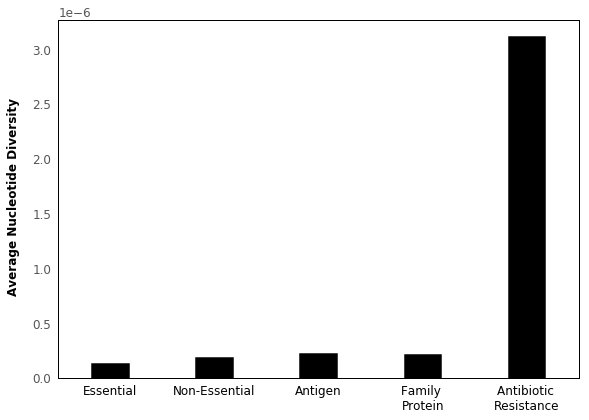

In [11]:
# PLOT
#to normalize bars by sample size
num_samples_pop = float(len(patient_list))
pop_norm_factor = float(1.0 / num_samples_pop)

#pop samples
########################################################################################################################
N = 5
width = 0.35       # the width of the bars
ind = np.arange(1 , N+1)

SNP_means = (np.mean(pop_SNP_Ess), np.mean(pop_SNP_Non_Ess), np.mean(pop_SNP_Ant), np.mean(pop_SNP_Fam_Protein), np.mean(pop_SNP_Antibiotic_Resistance))

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

fig , ax = plt.subplots()

rects_SNP = ax.bar(ind , SNP_means, width, color='black' , linewidth = 1.5 , edgecolor = 'k')

ax.set_xlim([0.5 , 5.5])
ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Essential' , 'Non-Essential', 'Antigen', 'Family \nProtein', 'Antibiotic \nResistance']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)

#label y-axis
fig.text(-0.01, 0.53, 'Average Nucleotide Diversity' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 12 , color = 'k')

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )


fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

### Boxplot

In [12]:
#create dataframe for boxplot
variant_measure = {}
Gene_Category = {}
gene_ids = {}

molded_DF_for_boxplot = pd.DataFrame()

df_indexer = 0
for gene_id in pop_number_variants_normalized_df.index:

    variant_meas_for_gene = pop_number_variants_normalized_df.loc[gene_id,:]
    
    #check to see if MGE
    if variant_meas_for_gene.Gene_Category != 'mobile_genetic_element':
        
        variant_measure[df_indexer] = variant_meas_for_gene.SNP_variant_measure
        Gene_Category[df_indexer] = variant_meas_for_gene.Gene_Category
        gene_ids[df_indexer] = gene_id

        df_indexer = df_indexer + 1
    
#convert to dataframe
variant_measure = pd.Series(variant_measure)
Gene_Category = pd.Series(Gene_Category)
Gene_IDs = pd.Series(gene_ids)

molded_DF_for_boxplot['variant_measure'] = variant_measure * pop_norm_factor #normalize by sample size
molded_DF_for_boxplot['Gene_Category'] = Gene_Category
molded_DF_for_boxplot['Gene_ID'] = Gene_IDs

#name boxplot something else
molded_DF_for_boxplot_Gene_Categories = molded_DF_for_boxplot

In [13]:
molded_DF_for_boxplot_Gene_Categories.head()

,variant_measure,Gene_Category,Gene_ID
0,0.000006,Non-Essential,Rv1086
1,0.000003,Non-Essential,Rv2434c
2,0.000006,Antigen,Rv0470c
3,0.000005,Non-Essential,Rv1124
4,0.000010,Non-Essential,Rv0139


In [14]:
molded_DF_for_boxplot_Gene_Categories.tail()

,variant_measure,Gene_Category,Gene_ID
3989,0.0,Non-Essential,Rv3920c
3990,0.0,Essential,Rv3921c
3991,0.0,Non-Essential,Rv3922c
3992,0.0,Essential,Rv3923c
3993,0.0,Non-Essential,Rv3924c


In [15]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 1.8

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='k' , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color='k' , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color='k' , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color='k' , linewidth = linewidth_for_box - 0.5)
    setp(bp['whiskers'][1], color='k' , linewidth = linewidth_for_box - 0.5)
    setp(bp['fliers'][0], color='k')
    setp(bp['medians'][0], color='k' , linewidth = 2.0)
    bp['fliers'][0].set_markerfacecolor('1.0')
    bp['fliers'][0].set_markeredgewidth(0.75)
    bp['fliers'][0].set_markersize(4.0)
    bp['fliers'][0].set_markeredgecolor('k')
    
def values_to_variant_types(values):
    
    SNP_vals = values.variant_measure
    
    return [SNP_vals]

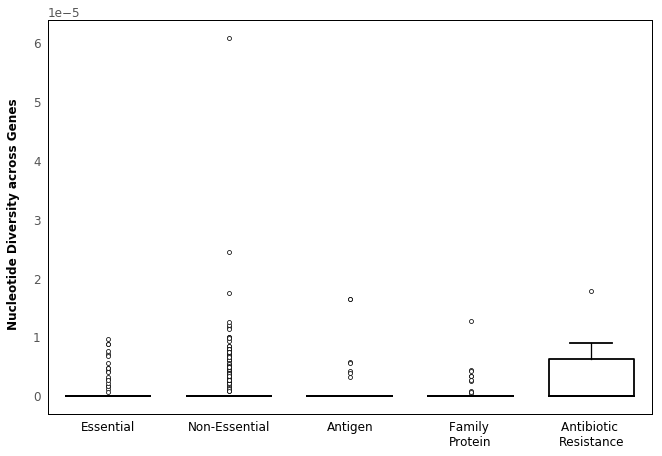

In [16]:
fig = plt.figure(1, figsize=(9, 6.5))
ax = axes()

#Essential Genes
Ess_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Essential']
bp = boxplot(values_to_variant_types(Ess_values) , positions = [1], widths = 0.7)
setBoxColors(bp)

#Non-Essential Genes
Non_Ess_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Non-Essential']
bp = boxplot(values_to_variant_types(Non_Ess_values) , positions = [2], widths = 0.7)
setBoxColors(bp)

#Antigen Genes
Ant_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antigen']
bp = boxplot(values_to_variant_types(Ant_values) , positions = [3], widths = 0.7)
setBoxColors(bp)

#Family Proteins
Fam_Protein_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'PE/PPE']
bp = boxplot(values_to_variant_types(Fam_Protein_values) , positions = [4], widths = 0.7)
setBoxColors(bp)

#Antibiotic Resistance
Anti_Resistance_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antibiotic Resistance']
bp = boxplot(values_to_variant_types(Anti_Resistance_values) , positions = [5], widths = 0.7)
setBoxColors(bp)

#label y-axis
fig.text(-0.01, 0.53, 'Nucleotide Diversity across Genes' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 12 , color = 'k')

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

xlim([0.5 , 5.5])
ax.set_ylabel('')

#x-axis
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Essential' , 'Non-Essential', 'Antigen', 'Family \nProtein', 'Antibiotic \nResistance']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

fig = plt.gcf()
fig.tight_layout()

plt.show()

#### Essential Genes that had some diversity

In [17]:
molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Essential'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Gene_Category,Gene_ID
87,0.000010,Essential,Rv1306
106,0.000009,Essential,Rv0716
123,0.000009,Essential,Rv1388
76,0.000008,Essential,Rv2700
55,0.000007,Essential,Rv1610


#### Non-Essential Genes that had some diversity

In [18]:
molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Non-Essential'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Gene_Category,Gene_ID
61,0.000061,Non-Essential,Rv0095c
47,0.000025,Non-Essential,Rv2128
53,0.000018,Non-Essential,Rv0105c
116,0.000013,Non-Essential,Rv1499
49,0.000012,Non-Essential,Rv3840


#### Antigen Genes that had some diversity

In [19]:
molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antigen'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Gene_Category,Gene_ID
16,0.000017,Antigen,Rv1641
104,0.000017,Antigen,Rv0192A
2,0.000006,Antigen,Rv0470c
84,0.000006,Antigen,Rv3803c
11,0.000004,Antigen,Rv0293c


#### PE/PPE Genes that had some diversity

In [20]:
molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'PE/PPE'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Gene_Category,Gene_ID
65,0.000013,PE/PPE,Rv3478
44,0.000004,PE/PPE,Rv3136
64,0.000004,PE/PPE,Rv1196
36,0.000003,PE/PPE,Rv0442c
60,0.000003,PE/PPE,Rv1818c


#### Antibiotic Resistance Genes that had some diversity

In [21]:
molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antibiotic Resistance'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Gene_Category,Gene_ID
89,0.000018,Antibiotic Resistance,Rv2043c
15,0.000009,Antibiotic Resistance,Rv1908c
52,0.000009,Antibiotic Resistance,Rv0667
70,0.000008,Antibiotic Resistance,Rv0006
68,0.000007,Antibiotic Resistance,Rv3919c


#### Compute Mann-Whitney U-test between nucleotide diversities for all gene categories

In [22]:
gene_categories_list = ['Essential' , 'Non-Essential' , 'Antigen' , 'PE/PPE' , 'Antibiotic Resistance']
MW_U_tests_DF = pd.DataFrame(index = gene_categories_list , columns = gene_categories_list) #DF to store p-values from Mann-Whitney U-tests

for gene_category_i in MW_U_tests_DF.index:
    
    #get nucleotide diversities for genes in category i
    I_nuc_diversities = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == gene_category_i].variant_measure
    
    for gene_category_j in MW_U_tests_DF.columns:
        
        #get nucleotide diversities for genes in category j
        J_nuc_diversities = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == gene_category_j].variant_measure
        
        #Mann Whitney U test for differences in AF changes between both categories
        non_parametric_test_pval = scipy.stats.mannwhitneyu(I_nuc_diversities , J_nuc_diversities)[1]
        MW_U_tests_DF.loc[gene_category_i , gene_category_j] = non_parametric_test_pval

In [23]:
MW_U_tests_DF

,Essential,Non-Essential,Antigen,PE/PPE,Antibiotic Resistance
Essential,0.499904,0.446664,0.487691,0.0223008,4.32762e-25
Non-Essential,0.446664,0.499988,0.452123,0.0132667,3.80059e-33
Antigen,0.487691,0.452123,0.49958,0.0528376,2.50078e-16
PE/PPE,0.0223008,0.0132667,0.0528376,0.49945,1.37989e-09
Antibiotic Resistance,4.32762e-25,3.80059e-33,2.50078e-16,1.37989e-09,0.496375


## [2] Antigens (Epitope vs. Non-Epitope)

In [24]:
############################################### ANTIGEN #######################################################################################

# POP samples - Antigen genes: Epitope vs Non-Epitope regions
# Function below takes DataFrame for each type of variant ( Syn & NSyn ) and returns two DataFrames corresponding to the variants for the epitope regions and non-epitope regions on Antigen genes.

antigen_genes = gene_categories[gene_categories.Gene_Category == 'Antigen'].index

#filter for subsetting patient-variant dataframes
antigen_filter_SNP = []
for gene_id in all_variants_genes_patients_SNP.index:
    antigen_filter_SNP.append(gene_id in antigen_genes)
    
def epitope_non_epitope_variants(all_variants_genes_patients_df, antigen_filter):

    #get list of antigen genes that have at least 1 variant (and thus would be represented in DF)
    relevant_antigen_genes = all_variants_genes_patients_df[antigen_filter].index

    antigen_epitope_variants_genes_patients_df = pd.DataFrame(index = relevant_antigen_genes, columns = all_variants_genes_patients_df.columns)
    antigen_non_epitope_variants_genes_patients_df = pd.DataFrame(index = relevant_antigen_genes, columns = all_variants_genes_patients_df.columns)

    #iterate through antigen genes only
    for antigen in relevant_antigen_genes:

        #iterate through patients
        for patient in all_variants_genes_patients_df.columns:

            epitope_variants = []
            non_epitope_variants = []

            #iterate through all base-wise variants (if there are any)
            for base_position_of_variant in all_variants_genes_patients_df.loc[antigen, patient]:

                variant_in_epitope = False
                #check to see if variant is in an epitope region
                relevant_epitope_peptide_seqs_genomic_coords = epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.loc[:, 'H37Rv Homolog'] == antigen]

                #iterate through epitope regions to see if variant 'lands' in one of them
                for row_i in relevant_epitope_peptide_seqs_genomic_coords.index:
                    genomic_range_start = np.min(relevant_epitope_peptide_seqs_genomic_coords.loc[row_i, ['start_peptide_genomic_coord', 'end_peptide_genomic_coord']])
                    genomic_range_end = np.max(relevant_epitope_peptide_seqs_genomic_coords.loc[row_i, ['start_peptide_genomic_coord', 'end_peptide_genomic_coord']])

                    #base-wise variant lies in epitope region
                    if (base_position_of_variant >= genomic_range_start) and (base_position_of_variant <= genomic_range_end):
                        epitope_variants.append(base_position_of_variant)
                        variant_in_epitope = True
                        break

                #if variant isn't assigned to an epitope, classify it as a non-epitope
                if variant_in_epitope == False:
                    non_epitope_variants.append(base_position_of_variant)

            #store gene_id - patient variant list (for both epitope and non-epitope regions in DFs)
            antigen_epitope_variants_genes_patients_df.loc[antigen, patient] = epitope_variants
            antigen_non_epitope_variants_genes_patients_df.loc[antigen, patient] = non_epitope_variants

    return [antigen_epitope_variants_genes_patients_df, antigen_non_epitope_variants_genes_patients_df]

######################################################################################################################################################

# Get all types of variants for epitope and non-epitope regions on Antigen genes
#synonymous variants
antigen_variants_SNP = epitope_non_epitope_variants(all_variants_genes_patients_SNP, antigen_filter_SNP)
antigen_epitope_variants_genes_patients_SNP = antigen_variants_SNP[0]
antigen_non_epitope_variants_genes_patients_SNP = antigen_variants_SNP[1]

######################################################################################################################################################

# Get Antigen gene lengths for all genes with at least 1 genetic variant and store in series (amongst all genes, then amongst antigen genes). SPLIT UP INTO EPITOPE AND NON-EPITOPE CONCATENATES.

#get list of antigen genes
gene_ids_antigens = list( set(antigen_epitope_variants_genes_patients_SNP.index) )

#dictionary, key: antigen gene, value: bool list of base positions, True if base position is in an epitope region
gene_epitope_region_boolean_dict = {}

for gene_id in gene_ids_antigens:
    gene_length = reference_genome_annotation.loc[gene_id].length
    gene_bool_list = [False] * gene_length #assume all base positions don't lie in epitope regions

    #iterate through epitope regions corresponding to gene and fill in True for relavent base positions
    relevant_peptides = epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.loc[:, 'H37Rv Homolog'] == gene_id]

    peptide_seqs_genomic_coordinates = zip( relevant_peptides.start_peptide_genomic_coord , relevant_peptides.end_peptide_genomic_coord )

    #iterate through the genomic coordinates for each peptide sequence associated with Antigen gene
    for peptide_seq_genomic_coords in peptide_seqs_genomic_coordinates:
        genomic_coord_start = np.min(peptide_seq_genomic_coords)
        genomic_coord_end = np.max(peptide_seq_genomic_coords)

        #flip every base position in bool list in between positions to True
        for base in range(int(genomic_coord_start) - 1 , int(genomic_coord_end) ):
            gene_bool_list[base] = True

    gene_epitope_region_boolean_dict[gene_id] = gene_bool_list

#gene lengths only for Antigens
gene_lengths_antigens_epitopes = pd.Series(index = gene_ids_antigens, name = 'gene_lengths_antigens_epitopes')
gene_lengths_antigens_non_epitopes = pd.Series(index = gene_ids_antigens, name = 'gene_lengths_antigens_non_epitopes')

for gene_id in gene_ids_antigens:

    #number of True's is the length of epitope concatenate
    gene_length_epitope = np.sum(gene_epitope_region_boolean_dict[gene_id])

    #number of False's is the length of the non-epitope concatenate
    gene_length_non_epitope = len(gene_epitope_region_boolean_dict[gene_id]) - gene_length_epitope

    gene_lengths_antigens_epitopes[gene_id] = gene_length_epitope
    gene_lengths_antigens_non_epitopes[gene_id] = gene_length_non_epitope

######################################################################################################################################################

#Get DataFrames storing SNP variants and transform them by counting the number of variants in each cell and dividing by the length of the respective gene, then adding measurements across all patients (measure nucleotide diversity) but now only for epitope and non-epitope regions on Antigen genes

#SNP variants
antigen_epitope_variants_genes_patients_SNP_transformed = antigen_epitope_variants_genes_patients_SNP.applymap(len)
antigen_epitope_variants_genes_patients_SNP_transformed = antigen_epitope_variants_genes_patients_SNP_transformed.applymap(np.float64)
number_SNP_antigen_epitope_variants_normalized = antigen_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1) / gene_lengths_antigens_epitopes[antigen_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1).index]

antigen_non_epitope_variants_genes_patients_SNP_transformed = antigen_non_epitope_variants_genes_patients_SNP.applymap(len)
antigen_non_epitope_variants_genes_patients_SNP_transformed = antigen_non_epitope_variants_genes_patients_SNP_transformed.applymap(np.float64)
number_SNP_antigen_non_epitope_variants_normalized = antigen_non_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1) / gene_lengths_antigens_non_epitopes[antigen_non_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1).index]


######################################################################################################################################################
# Create DataFrame to store measurements for all types of genetic variants and for epitope and non-epitope regions of Antigen genes.

#EPITOPE
#name each series
number_SNP_antigen_epitope_variants_normalized.name = 'SNP_variant_measure'
number_antigen_epitope_variants_normalized_df = pd.concat([number_SNP_antigen_epitope_variants_normalized], axis=1)

#get list of all genes that did not have any genetic variants in any patients
genes_with_no_variants = [gene_id for gene_id in gene_categories.index if gene_id not in number_antigen_epitope_variants_normalized_df.index]

#genes with no variants will be equal to zero across S & NS variant measurements
for gene_no_variant in genes_with_no_variants:
    number_antigen_epitope_variants_normalized_df.loc[gene_no_variant, :] = [0.0]

#Merge with Gene_Categories to get gene category for each gene
pop_number_antigen_epitope_variants_normalized_df = number_antigen_epitope_variants_normalized_df.merge(gene_categories, how='left', left_index = True, right_index = True)

#replace NaN's with zeros (needed if there are SNPs on the non-epitope regions but not on the epitope regions)
pop_number_antigen_epitope_variants_normalized_df.fillna(0.0 , inplace = True)

#NON-EPITOPE
number_SNP_antigen_non_epitope_variants_normalized.name = 'SNP_variant_measure'
number_antigen_non_epitope_variants_normalized_df = pd.concat([number_SNP_antigen_non_epitope_variants_normalized], axis=1)

#get list of all genes that did not have any genetic variants in any patients
genes_with_no_variants = [gene_id for gene_id in gene_categories.index if gene_id not in number_antigen_non_epitope_variants_normalized_df.index]

#genes with no variants will be equal to zero across SNP variant measurements
for gene_no_variant in genes_with_no_variants:
    number_antigen_non_epitope_variants_normalized_df.loc[gene_no_variant, :] = [0.0]

#Merge with Gene_Categories to get gene category for each gene
pop_number_antigen_non_epitope_variants_normalized_df = number_antigen_non_epitope_variants_normalized_df.merge(gene_categories, how='left', left_index = True, right_index = True)

#replace NaN's with zeros (needed if there are SNPs on the epitope regions but not on the non-epitope regions)
pop_number_antigen_non_epitope_variants_normalized_df.fillna(0.0 , inplace = True)

######################################################################################################################################################

#SNP variants
pop_SNP_Ant_epitope = pop_number_antigen_epitope_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_antigen_epitope_variants_normalized_df.Gene_Category == 'Antigen']
pop_SNP_Ant_non_epitope = pop_number_antigen_non_epitope_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_antigen_non_epitope_variants_normalized_df.Gene_Category == 'Antigen']

### Barplot

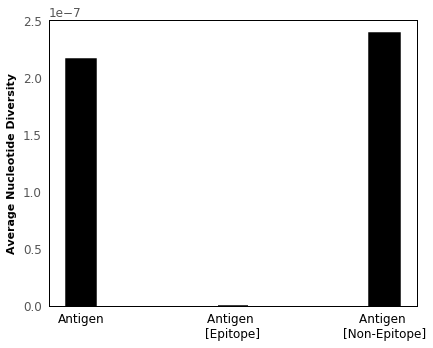

In [25]:
##################################################### PLOT ###################################################################################

#to normalize bars by sample size
num_samples_pop = float(len(patient_list))
pop_norm_factor = float(1.0 / num_samples_pop)

#pop samples
########################################################################################################################
N = 3
width = 0.2       # the width of the bars
ind = np.arange(1 , N+1)  # the x locations for the groups

SNP_means = ( np.mean(pop_SNP_Ant), np.mean(pop_SNP_Ant_epitope), np.mean(pop_SNP_Ant_non_epitope))

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

fig , ax = plt.subplots()

rects_SNP = ax.bar(ind, SNP_means, width, color='k' , linewidth = 1.5 , edgecolor = 'k')

#ax.set_xlim([0.4 , 3.35])
ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Antigen' , 'Antigen \n[Epitope]', 'Antigen \n[Non-Epitope]']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)

#label y-axis
fig.text(0.005, 0.53, 'Average Nucleotide Diversity' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 11 , color = 'k')
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

fig = plt.gcf()
fig.set_size_inches(6, 5)
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

### Boxplot

In [26]:
antigen_entire_gene_div = pop_number_variants_normalized_df[pop_number_variants_normalized_df.Gene_Category == 'Antigen']
antigen_epitope_div = pop_number_antigen_epitope_variants_normalized_df[pop_number_antigen_epitope_variants_normalized_df.Gene_Category == 'Antigen']
antigen_non_epitope_div = pop_number_antigen_non_epitope_variants_normalized_df[pop_number_antigen_non_epitope_variants_normalized_df.Gene_Category == 'Antigen']

#dictionary that stores DF for each type of gene split
concat_nuc_div_DF_dict = {'whole_gene':antigen_entire_gene_div , 'epitope':antigen_epitope_div , 'non_epitope':antigen_non_epitope_div}

#create dataframe for boxplot
variant_measure = {}
Concatenate_Category = {}
gene_ids = {}

molded_DF_for_boxplot = pd.DataFrame()

df_indexer = 0

for concatenate_type in concat_nuc_div_DF_dict.keys():
    
    pop_number_variants_normalized_df_concat_type = concat_nuc_div_DF_dict[concatenate_type]

    for gene_id in pop_number_variants_normalized_df_concat_type.index:

        variant_meas_for_gene = pop_number_variants_normalized_df_concat_type.loc[gene_id,:]

        variant_measure[df_indexer] = variant_meas_for_gene.SNP_variant_measure
        Concatenate_Category[df_indexer] = concatenate_type 
        gene_ids[df_indexer] = gene_id

        df_indexer = df_indexer + 1
    
#convert to dataframe
variant_measure = pd.Series(variant_measure)
Concatenate_Category = pd.Series(Concatenate_Category)
Gene_IDs = pd.Series(gene_ids)

molded_DF_for_boxplot['variant_measure'] = variant_measure * pop_norm_factor #normalize by sample size
molded_DF_for_boxplot['Concatenate_Category'] = Concatenate_Category
molded_DF_for_boxplot['Gene_ID'] = Gene_IDs

molded_DF_for_boxplot_antigen = molded_DF_for_boxplot

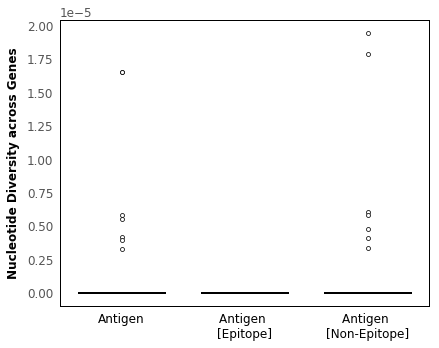

In [27]:
fig = plt.figure(1, figsize=(6, 5))
ax = axes()

#whole_genes
Ess_values = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'whole_gene']
bp = boxplot(values_to_variant_types(Ess_values) , positions = [1], widths = 0.7)
setBoxColors(bp)

#epitopes
Non_Ess_values = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'epitope']
bp = boxplot(values_to_variant_types(Non_Ess_values) , positions = [2], widths = 0.7)
setBoxColors(bp)

#non-epitopes
Ant_values = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'non_epitope']
bp = boxplot(values_to_variant_types(Ant_values) , positions = [3], widths = 0.7)
setBoxColors(bp)

#label y-axis
fig.text(0.0, 0.53, 'Nucleotide Diversity across Genes' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 12 , color = 'k')

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

xlim(0.5 , 3.5)
ax.set_ylabel('')

#x-axis
ax.set_xticks([1,2,3])
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Antigen' , 'Antigen \n[Epitope]', 'Antigen \n[Non-Epitope]']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

#### Antigen Epitopes that had some diversity

In [28]:
molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'epitope'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Concatenate_Category,Gene_ID
257,0.0,epitope,Rv0470c
386,0.0,epitope,Rv1987
420,0.0,epitope,Rv2819c
421,0.0,epitope,Rv2823c
422,0.0,epitope,Rv2855


#### Antigen Non-Epitopes that had some diversity

In [29]:
molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'non_epitope'].sort_values(by='variant_measure' , ascending = False).head(n=10)

,variant_measure,Concatenate_Category,Gene_ID
519,0.000019,non_epitope,Rv0192A
516,0.000018,non_epitope,Rv1641
514,0.000006,non_epitope,Rv0470c
518,0.000006,non_epitope,Rv3803c
515,0.000005,non_epitope,Rv0293c
520,0.000004,non_epitope,Rv1194c
517,0.000003,non_epitope,Rv0773c
685,0.000000,non_epitope,Rv2873
690,0.000000,non_epitope,Rv2955c
689,0.000000,non_epitope,Rv2945c


#### Compute wilcoxon signed-rank test between nucleotide diversities on epitope concatenates of Antigen Genes and non-epitope concatenates of Antigen Genes

In [30]:
gene_ID_list_antigens = list( molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'epitope'].Gene_ID )

antigen_epitope_nuc_diversities = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'epitope'].set_index('Gene_ID').loc[gene_ID_list_antigens , :].variant_measure
antigen_non_epitope_nuc_diversities = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'non_epitope'].set_index('Gene_ID').loc[gene_ID_list_antigens , :].variant_measure

#compute wilcoxon signed-rank test
non_parametric_test_pval = scipy.stats.wilcoxon(antigen_epitope_nuc_diversities , antigen_non_epitope_nuc_diversities)[1]

/home/rv76/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [31]:
non_parametric_test_pval

0.017960477526078766

## [3] PE/PPE (Epitope vs Non-Epitope)

In [32]:
############################################### Family-Protein #######################################################################################

# POP samples - Family Protein genes: Epitope vs Non-Epitope regions
# Function below takes DataFrame for each type of variant ( SNP ) and returns two DataFrames corresponding to the variants for the epitope regions and non-epitope regions on Family Protein genes.

family_protein_genes = gene_categories[gene_categories.Gene_Category == 'PE/PPE'].index

#filter for subsetting patient-variant dataframes
family_protein_filter_SNP = []
for gene_id in all_variants_genes_patients_SNP.index:
    family_protein_filter_SNP.append(gene_id in family_protein_genes)

def epitope_non_epitope_variants(all_variants_genes_patients_df, family_protein_filter):

    #get list of family_protein genes that have at least 1 variant (and thus would be represented in DF)
    relevant_family_protein_genes = all_variants_genes_patients_df[family_protein_filter].index

    family_protein_epitope_variants_genes_patients_df = pd.DataFrame(index = relevant_family_protein_genes, columns = all_variants_genes_patients_df.columns)
    family_protein_non_epitope_variants_genes_patients_df = pd.DataFrame(index = relevant_family_protein_genes, columns = all_variants_genes_patients_df.columns)

    #iterate through family_protein genes only
    for family_protein in relevant_family_protein_genes:

        #iterate through patients
        for patient in all_variants_genes_patients_df.columns:

            epitope_variants = []
            non_epitope_variants = []

            #iterate through all base-wise variants (if there are any)
            for base_position_of_variant in all_variants_genes_patients_df.loc[family_protein, patient]:

                variant_in_epitope = False
                #check to see if variant is in an epitope region
                relevant_epitope_peptide_seqs_genomic_coords = epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.loc[:, 'H37Rv Homolog'] == family_protein]

                #iterate through epitope regions to see if variant 'lands' in one of them
                for row_i in relevant_epitope_peptide_seqs_genomic_coords.index:
                    genomic_range_start = np.min(relevant_epitope_peptide_seqs_genomic_coords.loc[row_i, ['start_peptide_genomic_coord', 'end_peptide_genomic_coord']])
                    genomic_range_end = np.max(relevant_epitope_peptide_seqs_genomic_coords.loc[row_i, ['start_peptide_genomic_coord', 'end_peptide_genomic_coord']])

                    #base-wise variant lies in epitope region
                    if (base_position_of_variant >= genomic_range_start) and (base_position_of_variant <= genomic_range_end):
                        epitope_variants.append(base_position_of_variant)
                        variant_in_epitope = True
                        break

                #if variant isn't assigned to an epitope, classify it as a non-epitope
                if variant_in_epitope == False:
                    non_epitope_variants.append(base_position_of_variant)

            #store gene_id - patient variant list (for both epitope and non-epitope regions in DFs)
            family_protein_epitope_variants_genes_patients_df.loc[family_protein, patient] = epitope_variants
            family_protein_non_epitope_variants_genes_patients_df.loc[family_protein, patient] = non_epitope_variants

    return [family_protein_epitope_variants_genes_patients_df, family_protein_non_epitope_variants_genes_patients_df]

######################################################################################################################################################

# Get all types of variants for epitope and non-epitope regions on Family Protein genes
#synonymous variants
family_protein_variants_SNP = epitope_non_epitope_variants(all_variants_genes_patients_SNP, family_protein_filter_SNP)
family_protein_epitope_variants_genes_patients_SNP = family_protein_variants_SNP[0]
family_protein_non_epitope_variants_genes_patients_SNP = family_protein_variants_SNP[1]

######################################################################################################################################################

# Get Family Protein gene lengths for all genes with at least 1 genetic variant and store in series (amongst all genes, then amongst family protein genes). SPLIT UP INTO EPITOPE AND NON-EPITOPE CONCATENATES.

#get list of family protein genes
gene_ids_family_proteins = list( set(family_protein_epitope_variants_genes_patients_SNP.index) )

#dictionary, key: family protein gene, value: bool list of base positions, True if base position is in an epitope region
gene_epitope_region_boolean_dict = {}

for gene_id in gene_ids_family_proteins:
    gene_length = reference_genome_annotation.loc[gene_id].length
    gene_bool_list = [False] * gene_length #assume all base positions don't lie in epitope regions

    #iterate through epitope regions corresponding to gene and fill in True for relavent base positions
    relevant_peptides = epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.loc[:, 'H37Rv Homolog'] == gene_id]

    peptide_seqs_genomic_coordinates = zip( relevant_peptides.start_peptide_genomic_coord , relevant_peptides.end_peptide_genomic_coord )

    #iterate through the genomic coordinates for each peptide sequence associated with family_protein gene
    for peptide_seq_genomic_coords in peptide_seqs_genomic_coordinates:
        genomic_coord_start = np.min(peptide_seq_genomic_coords)
        genomic_coord_end = np.max(peptide_seq_genomic_coords)

        #flip every base position in bool list in between positions to True
        for base in range(int(genomic_coord_start) - 1 , int(genomic_coord_end) ):
            gene_bool_list[base] = True

    gene_epitope_region_boolean_dict[gene_id] = gene_bool_list

#gene lengths only for family_proteins
gene_lengths_family_proteins_epitopes = pd.Series(index = gene_ids_family_proteins, name = 'gene_lengths_family_proteins_epitopes')
gene_lengths_family_proteins_non_epitopes = pd.Series(index = gene_ids_family_proteins, name = 'gene_lengths_family_proteins_non_epitopes')

for gene_id in gene_ids_family_proteins:

    #number of True's is the length of epitope concatenate
    gene_length_epitope = np.sum(gene_epitope_region_boolean_dict[gene_id])

    #number of False's is the length of the non-epitope concatenate
    gene_length_non_epitope = len(gene_epitope_region_boolean_dict[gene_id]) - gene_length_epitope

    gene_lengths_family_proteins_epitopes[gene_id] = gene_length_epitope
    gene_lengths_family_proteins_non_epitopes[gene_id] = gene_length_non_epitope

######################################################################################################################################################

#Get DataFrames storing SNP variants and transform them by counting the number of variants in each cell and dividing by the length of the respective gene, then adding measurements across all patients (measure nucleotide diversity) but now only for epitope and non-epitope regions on Family Protein genes

#synonymous variants
family_protein_epitope_variants_genes_patients_SNP_transformed = family_protein_epitope_variants_genes_patients_SNP.applymap(len)
family_protein_epitope_variants_genes_patients_SNP_transformed = family_protein_epitope_variants_genes_patients_SNP_transformed.applymap(np.float64)
number_SNP_family_protein_epitope_variants_normalized = family_protein_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1) / gene_lengths_family_proteins_epitopes[family_protein_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1).index]

family_protein_non_epitope_variants_genes_patients_SNP_transformed = family_protein_non_epitope_variants_genes_patients_SNP.applymap(len)
family_protein_non_epitope_variants_genes_patients_SNP_transformed = family_protein_non_epitope_variants_genes_patients_SNP_transformed.applymap(np.float64)
number_SNP_family_protein_non_epitope_variants_normalized = family_protein_non_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1) / gene_lengths_family_proteins_non_epitopes[family_protein_epitope_variants_genes_patients_SNP_transformed.sum(axis = 1).index]

######################################################################################################################################################
# Create DataFrame to store measurements for all types of genetic variants and for epitope and non-epitope regions of family_protein genes.

#EPITOPE
#name each series
number_SNP_family_protein_epitope_variants_normalized.name = 'SNP_variant_measure' 
number_family_protein_epitope_variants_normalized_df = pd.concat([number_SNP_family_protein_epitope_variants_normalized], axis=1)

#get list of all genes that did not have any genetic variants in any patients
genes_with_no_variants = [gene_id for gene_id in gene_categories.index if gene_id not in number_family_protein_epitope_variants_normalized_df.index]

#genes with no variants will be equal to zero across S & NS variant measurements
for gene_no_variant in genes_with_no_variants:
    number_family_protein_epitope_variants_normalized_df.loc[gene_no_variant, :] = [0.0]

#Merge with Gene_Categories to get gene category for each gene
pop_number_family_protein_epitope_variants_normalized_df = number_family_protein_epitope_variants_normalized_df.merge(gene_categories, how='left', left_index = True, right_index = True)

#replace NaN's with zeros (needed if there are SNPs on the non-epitope regions but not on the epitope regions)
pop_number_family_protein_epitope_variants_normalized_df.fillna(0.0 , inplace = True)

#NON-EPITOPE
number_SNP_family_protein_non_epitope_variants_normalized.name = 'SNP_variant_measure'
number_family_protein_non_epitope_variants_normalized_df = pd.concat([number_SNP_family_protein_non_epitope_variants_normalized], axis=1)

#get list of all genes that did not have any genetic variants in any patients
genes_with_no_variants = [gene_id for gene_id in gene_categories.index if gene_id not in number_family_protein_non_epitope_variants_normalized_df.index]

#genes with no variants will be equal to zero across S, NS and G variant measurements
for gene_no_variant in genes_with_no_variants:
    number_family_protein_non_epitope_variants_normalized_df.loc[gene_no_variant, :] = [0.0]

#Merge with Gene_Categories to get gene category for each gene
pop_number_family_protein_non_epitope_variants_normalized_df = number_family_protein_non_epitope_variants_normalized_df.merge(gene_categories, how='left', left_index = True, right_index = True)

#replace NaN's with zeros (needed if there are SNPs on the epitope regions but not on the non-epitope regions)
pop_number_family_protein_non_epitope_variants_normalized_df.fillna(0.0 , inplace = True)

######################################################################################################################################################

#SNP variants
pop_SNP_Fam_Protein_epitope = pop_number_family_protein_epitope_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_family_protein_epitope_variants_normalized_df.Gene_Category == 'PE/PPE']
pop_SNP_Fam_Protein_non_epitope = pop_number_family_protein_non_epitope_variants_normalized_df.loc[:, 'SNP_variant_measure'][pop_number_family_protein_non_epitope_variants_normalized_df.Gene_Category == 'PE/PPE']

### Barplot

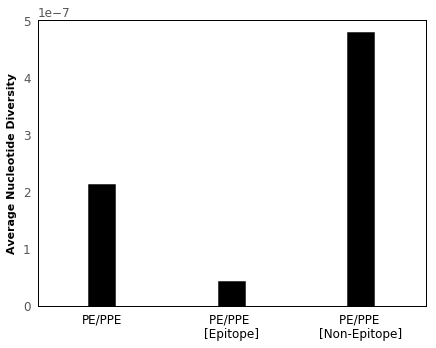

In [33]:
##################################################### PLOT ###################################################################################

#to normalize bars by sample size
num_samples_pop = float(len(patient_list))
pop_norm_factor = float(1.0 / num_samples_pop)

#pop samples
########################################################################################################################
N = 3
width = 0.20       # the width of the bars
ind = np.arange(1 , N+1)  # the x locations for the groups

SNP_means = ( np.mean(pop_SNP_Fam_Protein), np.mean(pop_SNP_Fam_Protein_epitope), np.mean(pop_SNP_Fam_Protein_non_epitope))

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

fig , ax = plt.subplots()

rects_SNP = ax.bar(ind , SNP_means, width, color='k' , linewidth = 1.5 , edgecolor = 'k')

ax.set_xlim([0.5 , 3.5])
ax.set_xticks(ind )
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['PE/PPE' , 'PE/PPE \n[Epitope]', 'PE/PPE \n[Non-Epitope]']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)

#label y-axis
fig.text(0.005, 0.53, 'Average Nucleotide Diversity' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 11 , color = 'k')
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

fig = plt.gcf()
fig.set_size_inches(6, 5)
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

### Boxplot

In [34]:
family_protein_entire_gene_div = pop_number_variants_normalized_df[pop_number_variants_normalized_df.Gene_Category == 'PE/PPE']
family_protein_epitope_div = pop_number_family_protein_epitope_variants_normalized_df[pop_number_family_protein_epitope_variants_normalized_df.Gene_Category == 'PE/PPE']
family_protein_non_epitope_div = pop_number_family_protein_non_epitope_variants_normalized_df[pop_number_family_protein_non_epitope_variants_normalized_df.Gene_Category == 'PE/PPE']

#dictionary that stores DF for each type of gene split
concat_nuc_div_DF_dict = {'whole_gene':family_protein_entire_gene_div , 'epitope':family_protein_epitope_div , 'non_epitope':family_protein_non_epitope_div}

#create dataframe for boxplot
variant_measure = {}
Concatenate_Category = {}
gene_ids = {}

molded_DF_for_boxplot = pd.DataFrame()

df_indexer = 0

for concatenate_type in concat_nuc_div_DF_dict.keys():
    
    pop_number_variants_normalized_df_concat_type = concat_nuc_div_DF_dict[concatenate_type]

    for gene_id in pop_number_variants_normalized_df_concat_type.index:

        variant_meas_for_gene = pop_number_variants_normalized_df_concat_type.loc[gene_id,:]

        variant_measure[df_indexer] = variant_meas_for_gene.SNP_variant_measure
        Concatenate_Category[df_indexer] = concatenate_type
        gene_ids[df_indexer] = gene_id

        df_indexer = df_indexer + 1
    
#convert to dataframe
variant_measure = pd.Series(variant_measure)
Concatenate_Category = pd.Series(Concatenate_Category)
Gene_IDs = pd.Series(gene_ids)

molded_DF_for_boxplot['variant_measure'] = variant_measure * pop_norm_factor #normalize by sample size
molded_DF_for_boxplot['Concatenate_Category'] = Concatenate_Category
molded_DF_for_boxplot['Gene_ID'] = Gene_IDs

molded_DF_for_boxplot_family_protein = molded_DF_for_boxplot

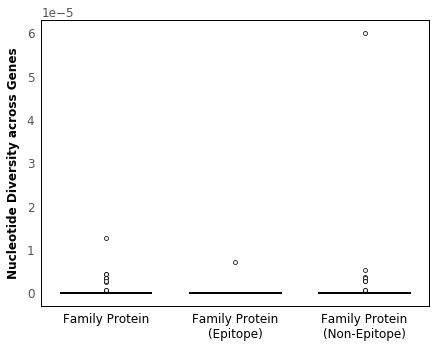

In [35]:
fig = plt.figure(1, figsize=(6, 5))
ax = axes()

#whole_genes
Ess_values = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'whole_gene']
bp = boxplot(values_to_variant_types(Ess_values) , positions = [1], widths = 0.7)
setBoxColors(bp)

#epitopes
Non_Ess_values = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'epitope']
bp = boxplot(values_to_variant_types(Non_Ess_values) , positions = [2], widths = 0.7)
setBoxColors(bp)

#non-epitopes
Ant_values = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'non_epitope']
bp = boxplot(values_to_variant_types(Ant_values) , positions = [3], widths = 0.7)
setBoxColors(bp)

#label y-axis
fig.text(0.0, 0.53, 'Nucleotide Diversity across Genes' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 12 , color = 'k')

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

xlim(0.5 , 3.5)
ax.set_ylabel('')

#x-axis
ax.set_xticks([1,2,3])
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Family Protein' , 'Family Protein\n(Epitope)', 'Family Protein\n(Non-Epitope)']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

#### PE/PPE Epitopes that had some diversity

In [36]:
molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'epitope'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Concatenate_Category,Gene_ID
172,0.000007,epitope,Rv1196
167,0.000000,epitope,Rv0304c
282,0.000000,epitope,Rv2608
274,0.000000,epitope,Rv2396
275,0.000000,epitope,Rv2408


#### PE/PPE Non-Epitopes that had some diversity

In [37]:
molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'non_epitope'].sort_values(by='variant_measure' , ascending = False).head(n=5)

,variant_measure,Concatenate_Category,Gene_ID
340,0.000060,non_epitope,Rv3478
337,0.000005,non_epitope,Rv3136
336,0.000004,non_epitope,Rv0442c
338,0.000003,non_epitope,Rv1818c
341,0.000003,non_epitope,Rv0755c


#### Compute wilcoxon signed-rank test between nucleotide diversities on epitope concatenates of PE/PPE Genes and non-epitope concatenates of PE/PPE Genes

In [38]:
gene_ID_list_family_proteins = list( molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'epitope'].Gene_ID )

family_protein_epitope_nuc_diversities = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'epitope'].set_index('Gene_ID').loc[gene_ID_list_family_proteins , :].variant_measure
family_protein_non_epitope_nuc_diversities = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'non_epitope'].set_index('Gene_ID').loc[gene_ID_list_family_proteins , :].variant_measure

#compute wilcoxon signed-rank test
non_parametric_test_pval = scipy.stats.wilcoxon(family_protein_epitope_nuc_diversities , family_protein_non_epitope_nuc_diversities)[1]

In [39]:
non_parametric_test_pval

0.05933611988090862

## [4] PE/PPE (PE vs PE-PGRS vs PPE)

#### Get lists of PE, PE-PGRS and PPE genes

In [40]:
PE_genes = list( reference_genome_annotation[reference_genome_annotation.description == 'PE family protein'].index )
PE_PGRS_genes = list( reference_genome_annotation[reference_genome_annotation.description == 'PE-PGRS family protein'].index )
PPE_genes = list( reference_genome_annotation[reference_genome_annotation.description == 'PPE family protein'].index )

#create filters for DF that holds nucleotide diversity measurements
PE_filter = []
for gene_id in pop_number_variants_normalized_df.index:
    PE_filter.append(gene_id in PE_genes)
    
PE_PGRS_filter = []
for gene_id in pop_number_variants_normalized_df.index:
    PE_PGRS_filter.append(gene_id in PE_PGRS_genes)
    
PPE_filter = []
for gene_id in pop_number_variants_normalized_df.index:
    PPE_filter.append(gene_id in PPE_genes)
    
#filter for nucleotide diversity measurements
pop_SNP_PE = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][PE_filter]
pop_SNP_PE_PGRS = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][PE_PGRS_filter]
pop_SNP_PPE = pop_number_variants_normalized_df.loc[:, 'SNP_variant_measure'][PPE_filter]

### Barplot

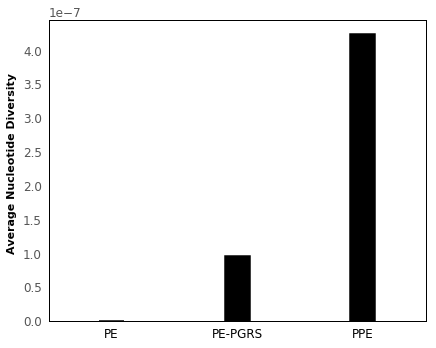

In [41]:
##################################################### PLOT ###################################################################################

#to normalize bars by sample size
num_samples_pop = float(len(patient_list))
pop_norm_factor = float(1.0 / num_samples_pop)

#pop samples
########################################################################################################################
N = 3
width = 0.20       # the width of the bars
ind = np.arange(1 , N+1)  # the x locations for the groups

SNP_means = ( np.mean(pop_SNP_PE) , np.mean(pop_SNP_PE_PGRS) , np.mean(pop_SNP_PPE) )

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

fig , ax = plt.subplots()

rects_SNP = ax.bar(ind , SNP_means, width, color='k' , linewidth = 1.5 , edgecolor = 'k')

ax.set_xlim([0.5 , 3.5])
ax.set_xticks(ind )
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['PE', 'PE-PGRS' , 'PPE']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)

#label y-axis
fig.text(0.005, 0.53, 'Average Nucleotide Diversity' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 11 , color = 'k')
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

fig = plt.gcf()
fig.set_size_inches(6, 5)
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

### Boxplot

In [42]:
#create dataframe for boxplot
variant_measure = {}
Gene_Category = {}
gene_ids = {}

molded_DF_for_boxplot = pd.DataFrame()

df_indexer = 0

for fam_protein_type, fam_protein_list in zip( ['PE' , 'PE-PGRS' , 'PPE'] , [PE_genes , PE_PGRS_genes , PPE_genes] ):
                                                                             
    for gene_id in fam_protein_list:

        variant_meas_for_gene = pop_number_variants_normalized_df.loc[gene_id,:]

        variant_measure[df_indexer] = variant_meas_for_gene.SNP_variant_measure
        Gene_Category[df_indexer] = fam_protein_type
        gene_ids[df_indexer] = gene_id

        df_indexer = df_indexer + 1
    
#convert to dataframe
variant_measure = pd.Series(variant_measure)
Gene_Category = pd.Series(Gene_Category)
Gene_IDs = pd.Series(gene_ids)

molded_DF_for_boxplot['variant_measure'] = variant_measure * pop_norm_factor #normalize by sample size
molded_DF_for_boxplot['Gene_Category'] = Gene_Category
molded_DF_for_boxplot['Gene_ID'] = Gene_IDs

#name boxplot something else
molded_DF_for_boxplot_family_protein_categories = molded_DF_for_boxplot

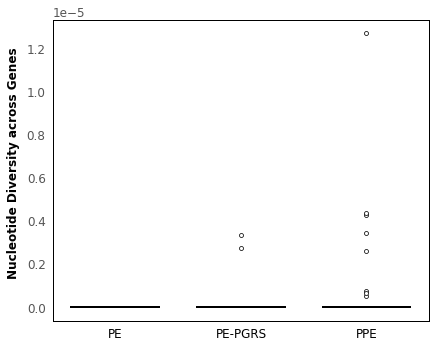

In [43]:
fig = plt.figure(1, figsize=(6, 5))
ax = axes()

#PE genes
PE_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE']
bp = boxplot(values_to_variant_types(PE_values) , positions = [1], widths = 0.7)
setBoxColors(bp)

#PE_PGRS genes
PE_PGRS_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE-PGRS']
bp = boxplot(values_to_variant_types(PE_PGRS_values) , positions = [2], widths = 0.7)
setBoxColors(bp)

#PPE genes
PPE_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PPE']
bp = boxplot(values_to_variant_types(PPE_values) , positions = [3], widths = 0.7)
setBoxColors(bp)

#label y-axis
fig.text(0.0, 0.53, 'Nucleotide Diversity across Genes' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 12 , color = 'k')

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
plt.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
plt.tick_params(axis='y', which='major', labelsize=12 )

xlim(0.5 , 3.5)
ax.set_ylabel('')

#x-axis
ax.set_xticks([1,2,3])
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['PE' , 'PE-PGRS', 'PPE']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

plt.show()

#### PE genes that had some diversity

In [44]:
molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE'].sort_values(by = 'variant_measure' , ascending = False).head(n=2)

,variant_measure,Gene_Category,Gene_ID
0,0.0,PE,Rv0151c
26,0.0,PE,Rv2769c


#### PPE genes that had some diversity

In [45]:
molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PPE'].sort_values(by = 'variant_measure' , ascending = False).head()

,variant_measure,Gene_Category,Gene_ID
158,0.000013,PPE,Rv3478
149,0.000004,PPE,Rv3136
116,0.000004,PPE,Rv1196
108,0.000003,PPE,Rv0442c
110,0.000003,PPE,Rv0755c


#### PE-PGRS genes that had some diversity

In [46]:
molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE-PGRS'].sort_values(by = 'variant_measure' , ascending = False).head()

,variant_measure,Gene_Category,Gene_ID
68,0.000003,PE-PGRS,Rv1818c
49,0.000003,PE-PGRS,Rv0872c
77,0.000000,PE-PGRS,Rv2487c
82,0.000000,PE-PGRS,Rv2741
81,0.000000,PE-PGRS,Rv2634c


#### Compute Mann-Whitney U-test between nucleotide diversities between PE, PPE & PE-PGRS genes

In [47]:
gene_categories_list = ['PE' , 'PPE' , 'PE-PGRS']
MW_U_tests_DF = pd.DataFrame(index = gene_categories_list , columns = gene_categories_list) #DF to store p-values from Mann-Whitney U-tests

for gene_category_i in MW_U_tests_DF.index:
    
    #get nucleotide diversities for genes in category i
    I_nuc_diversities = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == gene_category_i].variant_measure
    
    for gene_category_j in MW_U_tests_DF.columns:
        
        if gene_category_i != gene_category_j:
        
            #get nucleotide diversities for genes in category j
            J_nuc_diversities = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == gene_category_j].variant_measure

            #Mann Whitney U test for differences in AF changes between both categories
            non_parametric_test_pval = scipy.stats.mannwhitneyu(I_nuc_diversities , J_nuc_diversities)[1]
            MW_U_tests_DF.loc[gene_category_i , gene_category_j] = non_parametric_test_pval

In [48]:
MW_U_tests_DF

,PE,PPE,PE-PGRS
PE,NaN,0.0189028,0.150071
PPE,0.0189028,NaN,0.0331106
PE-PGRS,0.150071,0.0331106,NaN


## [5] Gridspec Figure of all Plots

In [49]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 1.0

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color)
    setp(bp['medians'][0], color=color , linewidth = 0.85)
    bp['fliers'][0].set_markerfacecolor(color)
    bp['fliers'][0].set_markeredgewidth(0.4)
    bp['fliers'][0].set_markersize(2.0)
    bp['fliers'][0].set_markeredgecolor('white')
    
def values_to_variant_types(values):
    
    SNP_vals = values.variant_measure
    
    return [SNP_vals]

def color_bar(bar , color):
    bar.set_color(color)
    bar.set_edgecolor('k')
    bar.set_linewidth(1.0)

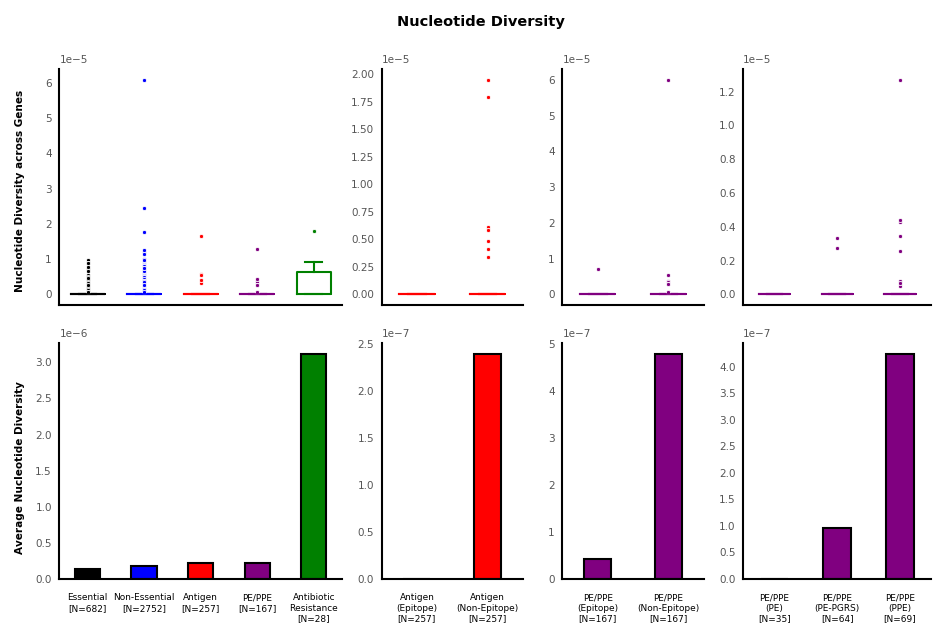

In [50]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 5})

##########################################################################################
fig = plt.figure(figsize=(7.5, 4.5), dpi=150)
gs = gridspec.GridSpec(2, 4,
                       width_ratios=[2 , 1 , 1 , 1.33],
                       height_ratios=[1 , 1],
                       wspace=0.21,
                       hspace=0.16)

y_tick_label_padding = 0.1

#Average Nucleotide Diversities
ax0 = fig.add_subplot(gs[1,0], frameon=True)
ax1 = fig.add_subplot(gs[0,0], frameon=True)

#Antigen Plots
ax2 = fig.add_subplot(gs[1,1], frameon=True)
ax3 = fig.add_subplot(gs[0,1], frameon=True)

#PE/PPE Plots
ax4 = fig.add_subplot(gs[1,2], frameon=True)
ax5 = fig.add_subplot(gs[0,2], frameon=True)

#Family Protein by PE, PE-PGRS, PPE Plots
ax9 = fig.add_subplot(gs[1,3], frameon=True)
ax10 = fig.add_subplot(gs[0,3], frameon=True)

#to normalize bars by sample size
num_samples_pop = float(len(patient_list))
pop_norm_factor = float(1.0 / num_samples_pop)

##########################################################################################
##########################################################################################

width = 0.45       # the width of the bars
ind = [1,2,3,4,5]

SNP_means = (np.mean(pop_SNP_Ess), np.mean(pop_SNP_Non_Ess), np.mean(pop_SNP_Ant), np.mean(pop_SNP_Fam_Protein), np.mean(pop_SNP_Antibiotic_Resistance) )

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

rects_SNP = ax0.bar(ind , SNP_means, width, color='k' , linewidth = 1.0 , edgecolor = 'k')
color_bar(rects_SNP[0] , 'k')
color_bar(rects_SNP[1] , 'b')
color_bar(rects_SNP[2] , 'r')
color_bar(rects_SNP[3] , 'purple')
color_bar(rects_SNP[4] , 'green')

ax0.set_xlim([0.5 , 5.5])
ax0.set_xticks(ind)
ax0.set_xticklabels([], rotation='horizontal', fontsize = 6)
ax0.yaxis.set_major_formatter(plt.ScalarFormatter())
ax0.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax0.tick_params(axis='y', which='major', labelsize= 5 , pad = y_tick_label_padding)


ax0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax0.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

##########################################################################################
box_width = 0.6

#Essential Genes
Ess_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Essential']
bp = ax1.boxplot(values_to_variant_types(Ess_values) , positions = [ind[0]], widths = box_width)
setBoxColors(bp , 'k')

#Non-Essential Genes
Non_Ess_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Non-Essential']
bp = ax1.boxplot(values_to_variant_types(Non_Ess_values) , positions = [ind[1]], widths = box_width)
setBoxColors(bp , 'b')

#Antigen Genes
Ant_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antigen']
bp = ax1.boxplot(values_to_variant_types(Ant_values) , positions = [ind[2]], widths = box_width)
setBoxColors(bp , 'r')

#Family Proteins
Fam_Protein_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'PE/PPE']
bp = ax1.boxplot(values_to_variant_types(Fam_Protein_values) , positions = [ind[3]], widths = box_width)
setBoxColors(bp , 'purple')

#Antibiotic Resistance
Anti_Resistance_values = molded_DF_for_boxplot_Gene_Categories[molded_DF_for_boxplot_Gene_Categories.Gene_Category == 'Antibiotic Resistance']
bp = ax1.boxplot(values_to_variant_types(Anti_Resistance_values) , positions = [ind[4]], widths = box_width)
setBoxColors(bp , 'green')

ax1.yaxis.set_major_formatter(plt.ScalarFormatter())
ax1.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax1.tick_params(axis='y', which='major', labelsize=5 , pad = y_tick_label_padding)

x_labels = ['Essential\n[N=' + str(len(Ess_values)) + ']', 'Non-Essential\n[N=' + str(len(Non_Ess_values)) + ']', 'Antigen\n[N=' + str(len(Ant_values)) + ']', 'PE/PPE\n[N=' + str(len(Fam_Protein_values)) + ']', 'Antibiotic\nResistance\n[N=' + str(len(Anti_Resistance_values)) + ']']
ax0.set_xticklabels(x_labels, rotation='horizontal', fontsize = 4.3)

ax1.set_xlim([0.5 , 5.5])
ax1.xaxis.set_visible(False)
ax1.xaxis.set_ticks_position('none')  

ax1.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

##########################################################################################
#Antigens
##########################################################################################
width = 0.38       # the width of the bars
ind = [1,2]

SNP_means = (np.mean(pop_SNP_Ant_epitope), np.mean(pop_SNP_Ant_non_epitope) )

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

rects_SNP = ax2.bar(ind , SNP_means, width, color='k' , linewidth = 1.0 , edgecolor = 'k')
color_bar(rects_SNP[0] , 'r')
color_bar(rects_SNP[1] , 'r')

ax2.set_xlim([0.5 , 2.5])
ax2.set_xticks(ind)
ax2.set_xticklabels([], rotation='horizontal', fontsize = 6)


ax2.yaxis.set_major_formatter(plt.ScalarFormatter())
ax2.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax2.tick_params(axis='y', which='major', labelsize= 5 , pad = y_tick_label_padding)


ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax2.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

##########################################################################################
box_width = 0.5

#ANTIGEN BREAKDOWN
#epitopes
Ant_epi_values = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'epitope']
bp = ax3.boxplot(values_to_variant_types(Ant_epi_values) , positions = [ind[0]], widths = box_width )
setBoxColors(bp , 'r')

#non-epitopes
Ant_non_epi_values = molded_DF_for_boxplot_antigen[molded_DF_for_boxplot_antigen.Concatenate_Category == 'non_epitope']
bp = ax3.boxplot(values_to_variant_types(Ant_non_epi_values) , positions = [ind[1]], widths = box_width )
setBoxColors(bp , 'r')

ax3.yaxis.set_major_formatter(plt.ScalarFormatter())
ax3.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax3.tick_params(axis='y', which='major', labelsize=5 , pad = y_tick_label_padding)

x_labels = ['Antigen\n(Epitope)\n[N=' + str(len(Ant_epi_values)) + ']', 'Antigen\n(Non-Epitope)\n[N=' + str(len(Ant_non_epi_values)) + ']']
ax2.set_xticklabels(x_labels, rotation='horizontal', fontsize = 4.3)

ax3.set_xlim([0.5 , 2.5])
ax3.xaxis.set_visible(False)
ax3.xaxis.set_ticks_position('none')  

ax3.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

##########################################################################################
#PE/PPE
##########################################################################################
width = 0.38   # the width of the bars
ind = [1,2]

SNP_means = ( np.mean(pop_SNP_Fam_Protein_epitope), np.mean(pop_SNP_Fam_Protein_non_epitope) )

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

rects_SNP = ax4.bar(ind , SNP_means, width, color='k' , linewidth = 1.0 , edgecolor = 'k')
color_bar(rects_SNP[0] , 'purple')
color_bar(rects_SNP[1] , 'purple')

ax4.set_xlim([0.5 , 2.5])
ax4.set_xticks(ind)
ax4.set_xticklabels([], rotation='horizontal', fontsize = 6)

ax4.yaxis.set_major_formatter(plt.ScalarFormatter())
ax4.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax4.tick_params(axis='y', which='major', labelsize= 5 , pad = y_tick_label_padding)

ax4.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax4.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

##########################################################################################
box_width = 0.5

#PE/PPE BREAKDOWN
#epitopes
FP_epi_values = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'epitope']
bp = ax5.boxplot(values_to_variant_types(FP_epi_values) , positions = [ind[0]], widths = box_width)
setBoxColors(bp, 'purple')

#non-epitopes
FP_non_epi_values = molded_DF_for_boxplot_family_protein[molded_DF_for_boxplot_family_protein.Concatenate_Category == 'non_epitope']
bp = ax5.boxplot(values_to_variant_types(FP_non_epi_values) , positions = [ind[1]], widths = box_width)
setBoxColors(bp, 'purple')

ax5.yaxis.set_major_formatter(plt.ScalarFormatter())
ax5.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax5.tick_params(axis='y', which='major', labelsize=5 , pad = y_tick_label_padding)

x_labels = ['PE/PPE\n(Epitope)\n[N=' + str(len(FP_epi_values)) + ']', 'PE/PPE\n(Non-Epitope)\n[N=' + str(len(FP_epi_values)) + ']']
ax4.set_xticklabels(x_labels, rotation='horizontal', fontsize = 4.3)

ax5.set_xlim([0.5 , 2.5])
ax5.xaxis.set_visible(False)
ax5.xaxis.set_ticks_position('none')  

ax5.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

##########################################################################################
#PE/PPE (by PE , PE-PGRS , PPE categories)
##########################################################################################
width = 0.44       # the width of the bars
ind = [1,2,3]

SNP_means = ( np.mean(pop_SNP_PE) , np.mean(pop_SNP_PE_PGRS) , np.mean(pop_SNP_PPE) )

#normalize by sample size
SNP_means = tuple(pop_norm_factor*x for x in SNP_means)

rects_SNP = ax9.bar(ind , SNP_means, width, color='k' , linewidth = 1.0 , edgecolor = 'k')
color_bar(rects_SNP[0] , 'purple')
color_bar(rects_SNP[1] , 'purple')
color_bar(rects_SNP[2] , 'purple')

ax9.set_xlim([0.5 , 3.5])
ax9.set_xticks(ind)
ax9.set_xticklabels([], rotation='horizontal', fontsize = 6)

ax9.yaxis.set_major_formatter(plt.ScalarFormatter())
ax9.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax9.tick_params(axis='y', which='major', labelsize= 5 , pad = y_tick_label_padding)

ax9.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax9.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)

##########################################################################################
box_width = 0.5

#PE/PPE breakdown by gene category

#PE genes
PE_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE']
bp = ax10.boxplot(values_to_variant_types(PE_values) , positions = [ind[0]], widths = box_width)
setBoxColors(bp , 'purple')

#PE_PGRS genes
PE_PGRS_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PE-PGRS']
bp = ax10.boxplot(values_to_variant_types(PE_PGRS_values) , positions = [ind[1]], widths = box_width)
setBoxColors(bp , 'purple')

#PPE genes
PPE_values = molded_DF_for_boxplot_family_protein_categories[molded_DF_for_boxplot_family_protein_categories.Gene_Category == 'PPE']
bp = ax10.boxplot(values_to_variant_types(PPE_values) , positions = [ind[2]], widths = box_width)
setBoxColors(bp , 'purple')

ax10.yaxis.set_major_formatter(plt.ScalarFormatter())
ax10.ticklabel_format(style='sci' , axis = 'y' , scilimits=(0,0))
ax10.tick_params(axis='y', which='major', labelsize=5 , pad = y_tick_label_padding)

x_labels = ['PE/PPE\n(PE)\n[N=' + str(len(PE_values)) + ']', 'PE/PPE\n(PE-PGRS)\n[N=' + str(len(PE_PGRS_values)) + ']' , 'PE/PPE\n(PPE)\n[N=' + str(len(PPE_values)) + ']']
ax9.set_xticklabels(x_labels, rotation='horizontal', fontsize = 4.3)

ax10.set_xlim([0.5 , 3.5])
ax10.xaxis.set_visible(False)
ax10.xaxis.set_ticks_position('none')  

ax10.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)

#Labels
#label y-axis
fig.text(0.09, 0.7, 'Nucleotide Diversity across Genes' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 5 , color = 'k')
fig.text(0.09, 0.29, 'Average Nucleotide Diversity' ,  ha='center', va='center', rotation=90, fontweight = 'bold', fontsize = 5 , color = 'k')
fig.text(0.5, 0.95, 'Nucleotide Diversity' ,  ha='center', va='center', rotation=0, fontweight = 'bold', fontsize = 7 , color = 'k')

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/nucleotide_diversity_across_gene_classes_from_SNPs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

## [6] Analysis of Epitopes

In [51]:
epitope_peptide_seqs_genomic_coords.head()

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord
Unnamed: 0,,,,,
0,AAAAKLAGLVFPQPPAPIAV,Rv3878,14-33,39.0,99.0
1,AAAGFASKTPANQAISMIDG,Rv0934,284-303,849.0,909.0
2,AAASAIQGNVTSIHSL,Rv3875,13-28,36.0,84.0
3,AADMWGPSSDPAWER,Rv1886c,216-230,327.0,288.0
4,AAGGHNAVFNFPPNG,Rv1886c,286-300,117.0,78.0


In [52]:
sum( all_variants_genes_patients_SNP_transformed.sum(axis = 1) ) #make sure all SNPs are accounted for

154.0

#### Concatenate lists of all genomic variants for each gene into 1 list (concatenate across all patients)

In [53]:
#create a dictionary to store the genomic coordinates for all SNPs for each gene
gene_SNPs_dict = {}

for gene_id in all_variants_genes_patients_SNP.index:
    
    SNPs_for_gene_id = []
    
    SNP_lists_by_patient_for_gene_i = all_variants_genes_patients_SNP.loc[gene_id , :]
    
    for SNP_list_patient_i in list(SNP_lists_by_patient_for_gene_i):
        
        SNPs_for_gene_id = SNPs_for_gene_id + SNP_list_patient_i
        
    gene_SNPs_dict[gene_id] = SNPs_for_gene_id

#### Iterate through epitopes and see how many variants 'landed' on each one

In [54]:
num_SNPs_on_epitope_list = []

for epitope_i in epitope_peptide_seqs_genomic_coords.index:
    
    #default to having no variants on epitope unless 1 is found that has been called
    num_variants_on_epitope = 0
    
    #pull information for epitope
    epitope_gene_id = epitope_peptide_seqs_genomic_coords.loc[epitope_i , 'H37Rv Homolog']
    epitope_gene_start = epitope_peptide_seqs_genomic_coords.loc[epitope_i , 'start_peptide_genomic_coord']
    epitope_gene_end = epitope_peptide_seqs_genomic_coords.loc[epitope_i , 'end_peptide_genomic_coord']
    
    #pull SNP information for gene (if gene had any SNPs called on it)
    if epitope_gene_id in gene_SNPs_dict.keys():
        SNPs_on_gene_id = gene_SNPs_dict[epitope_gene_id]

        #check to see if any of the SNPs that occurred on the gene, occurred on the epitope
        for SNP_i in SNPs_on_gene_id:

            if (SNP_i > min(epitope_gene_start , epitope_gene_end) ) and (SNP_i < max(epitope_gene_start , epitope_gene_end) ):

                num_variants_on_epitope += 1
            
    #store number of variants for epitope
    num_SNPs_on_epitope_list.append(num_variants_on_epitope)

#### Append number of SNP changes per epitope to DF

In [55]:
epitope_peptide_seqs_genomic_coords['SNPs_on_epitope'] = num_SNPs_on_epitope_list

#### Look at epitopes that had at least 1 SNP (and output to CSV)

In [56]:
epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.SNPs_on_epitope > 0.0].sort_values(by='SNPs_on_epitope' , ascending = False)

,Peptide,H37Rv Homolog,Rv position #,start_peptide_genomic_coord,end_peptide_genomic_coord,SNPs_on_epitope
Unnamed: 0,,,,,,
752,LIATNLLGQNTPAIAVNEAE,Rv1196,121-140,360.0,420.0,1
795,TPAIAVNEAEYGEMWAQDAA,Rv1196,131-150,390.0,450.0,1
1672,LIATNLLGQNTPAIA,Rv1196,121-135,360.0,405.0,1
1674,LLGQNTPAIAVNEAE,Rv1196,126-140,375.0,420.0,1
1742,TPAIAVNEAEYGEMW,Rv1196,131-145,390.0,435.0,1


#### Export a CSV file with all of the epitopes tagged with a count of how many SNPs were observed in each epitope

In [57]:
epitope_peptide_seqs_genomic_coords.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/epitope_analysis/ALL_epitopes_with_SNPs.csv')

In [58]:
epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.SNPs_on_epitope > 0.0].sort_values(by='SNPs_on_epitope' , ascending = False).to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/epitope_peptide_sequences/epitope_analysis/epitopes_with_SNPs.csv')

In [59]:
from collections import Counter

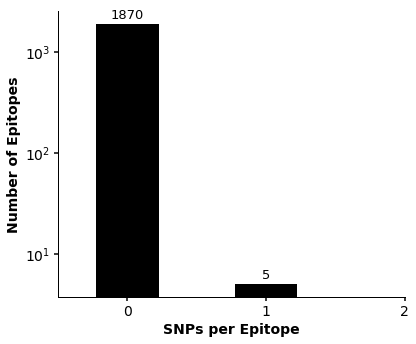

In [60]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=2
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom' , fontsize = 13.0)
        
num_SNPs_per_epitope = pd.Series( Counter( epitope_peptide_seqs_genomic_coords.SNPs_on_epitope ) , name = 'num_SNPs')
number_of_epitopes = len(epitope_peptide_seqs_genomic_coords.loc[: , 'SNPs_on_epitope'])


fig , ax = plt.subplots()

epitope_hist = plt.bar(num_SNPs_per_epitope.index , num_SNPs_per_epitope.values , color = 'k' , width = 0.45)

plt.xlabel('SNPs per Epitope', fontweight = 'bold' , fontsize = 14, color = 'k')
plt.ylabel('Number of Epitopes' , fontweight = 'bold' , fontsize = 14, color = 'k')

epitope_rects = ax.patches
autolabel(epitope_rects)

ax.set_xlim(-.5 , max( num_SNPs_per_epitope.index ) + .5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yscale("log", nonposy='clip')

ax.set_xticks([0,1,2], minor=False)
ax.set_xticklabels(['0' , '1' , '2'], rotation='horizontal', fontsize = 14)

ax.tick_params(direction='out', length=4, width=1.5, colors='k') #make tick marks darker
plt.minorticks_off() #turn minor ticks off

ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')


fig = plt.gcf()
fig.set_size_inches(6.0, 5.0)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/distribution_of_variants_on_epitopes_from_SNPs.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### All Genes that had at least 1 within-host SNP on an epitope across all subjects

In [61]:
print set( list( epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.SNPs_on_epitope > 0.0].loc[: , 'H37Rv Homolog'] ) )  

set(['Rv1196'])


In [62]:
reference_genome_annotation.symbol[list(set( list( epitope_peptide_seqs_genomic_coords[epitope_peptide_seqs_genomic_coords.SNPs_on_epitope > 0.0].loc[: , 'H37Rv Homolog'] ) )  )]

name
Rv1196    PPE18
Name: symbol, dtype: object